In [1]:
import pandas as pd
import seaborn as sb

df = pd.read_csv('simulated_transaction_2024.csv')

C:\Users\carlo\AppData\Local\Temp\ipykernel_22156\86173720.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import pandas as pd

# Ensure 'Amount' is treated as a float if it's not already
df['Amount'] = df['Amount'].astype(float)

# Group by Account No and Third Party Name, then sum and count transactions
grouped = df.groupby(['Account No', 'Third Party Name'])
summed = grouped['Amount'].sum().reset_index(name='Total Amount')
counts = grouped.size().reset_index(name='Counts')

# Find the Third Party Name with the highest total transaction amount per account
top_by_amount = summed.loc[summed.groupby('Account No')['Total Amount'].idxmax()]

# Find the most frequent Third Party Name per account
most_frequent = counts.loc[counts.groupby('Account No')['Counts'].idxmax()]

# Merge the results on 'Account No'
merged = pd.merge(top_by_amount, most_frequent, on='Account No', suffixes=('_top_amount', '_most_freq'))

# Select the relevant columns to avoid duplicates
final_subset = merged[['Account No', 'Third Party Name_top_amount', 'Third Party Name_most_freq']]

# Display the final subset
print(final_subset)


      Account No Third Party Name_top_amount Third Party Name_most_freq
0    101531259.0                  Hobbycraft                      Tesco
1    104832000.0                A Yarn Story                      Tesco
2    105375973.0                  Coop Local              Sports Direct
3    106601471.0                  Hobbycraft                      Tesco
4    108481285.0             Happy Days Home                     Amazon
..           ...                         ...                        ...
971  995615876.0                     Matalan                    Matalan
972  996042490.0             Lloyds Pharmacy                      Tesco
973  998390769.0                  Kings Arms                      Tesco
974  998405607.0             Five Senses Art                      Tesco
975  999752672.0                         CPA                  Coffee #1

[976 rows x 3 columns]


In [3]:
# Group by 'Third Party Name' to identify transaction counts and averages
analysis = df.groupby('Third Party Name').agg(
    Transaction_Count=('Amount', 'count'),
    Average_Transaction_Amount=('Amount', 'mean')
).reset_index().sort_values(by='Transaction_Count', ascending=False)

In [4]:
analysis

,Third Party Name,Transaction_Count,Average_Transaction_Amount
72,Tesco,34073,-66.073070
67,Sports Direct,16248,-61.277883
75,Topshop,10328,-103.670630
20,Fat Face,9537,-47.702281
57,PureGym,8286,-18.990000
...,...,...,...
48,Millets,1,-70.000000
50,Mothercare,1,-280.000000
51,Mountain Warehouse,1,-30.000000
66,Specsavers,1,-270.000000


In [5]:
# Example segmentation by transaction volume
volume_segments = df.groupby('Account No').agg(
    Total_Spent=('Amount', 'sum'),
    Transaction_Count=('Amount', 'count')
).reset_index()

# Define segments based on criteria (e.g., high spenders, frequent shoppers)
volume_segments['Customer_Segment'] = pd.cut(volume_segments['Total_Spent'],
                                              bins=[-float('inf'), -1000, 0, float('inf')],
                                              labels=['Savers', 'Moderate Spenders', 'High Spenders'])

In [6]:
volume_segments

,Account No,Total_Spent,Transaction_Count,Customer_Segment
0,101531259.0,-716.08,122,Moderate Spenders
1,104832000.0,-4565.52,164,Savers
2,105375973.0,-193.77,158,Moderate Spenders
3,106601471.0,10649.00,192,High Spenders
4,108481285.0,10038.92,368,High Spenders
...,...,...,...,...
971,995615876.0,1428.73,184,High Spenders
972,996042490.0,5981.99,254,High Spenders
973,998390769.0,-1823.35,152,Savers
974,998405607.0,-2016.16,159,Savers


In [7]:
import pandas as pd

# Assuming 'df' is your DataFrame with the bank transactions
# Calculate the required metrics for each customer (account number)

# Group the data by 'Account No' and calculate the mean balance and mean amount for each account
customer_metrics = df.groupby('Account No').agg(
    Average_Balance=('Balance', 'mean'),
    Average_Amount=('Amount', 'mean'),
).reset_index()

# Calculate the transaction count for each account
customer_metrics['Transaction_Count'] = df.groupby('Account No')['Amount'].count().reset_index(drop=True)

# Now 'customer_metrics' DataFrame will have 'Account No', 'Average_Balance', 'Average_Amount', and 'Transaction_Count' fields

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Preparing the dataset for clustering
X = customer_metrics[['Average_Balance', 'Average_Amount', 'Transaction_Count']].values

# Standardizing the data to ensure equal importance is given to all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Running K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Choosing 4 clusters arbitrarily; adjust based on domain knowledge or use methods like the elbow method to choose the optimal number
kmeans.fit(X_scaled)

# Assigning the cluster labels to each customer
customer_metrics['Cluster'] = kmeans.labels_

# Checking the distribution of customers in each cluster
cluster_distribution = customer_metrics['Cluster'].value_counts()

# Displaying the first few rows to see the segmentation results along with the cluster distribution
print(customer_metrics.head())
print("\nCluster Distribution:\n", cluster_distribution)

    Account No  Average_Balance  Average_Amount  Transaction_Count  Cluster
0  101531259.0       263.174172       -5.869508                122        0
1  104832000.0     -1188.593268      -27.838537                164        1
2  105375973.0       110.995337       -1.226392                158        0
3  106601471.0      6850.181133       55.463542                192        3
4  108481285.0      6830.116572       27.279674                368        2

Cluster Distribution:
 Cluster
0    540
1    224
2    158
3     54
Name: count, dtype: int64


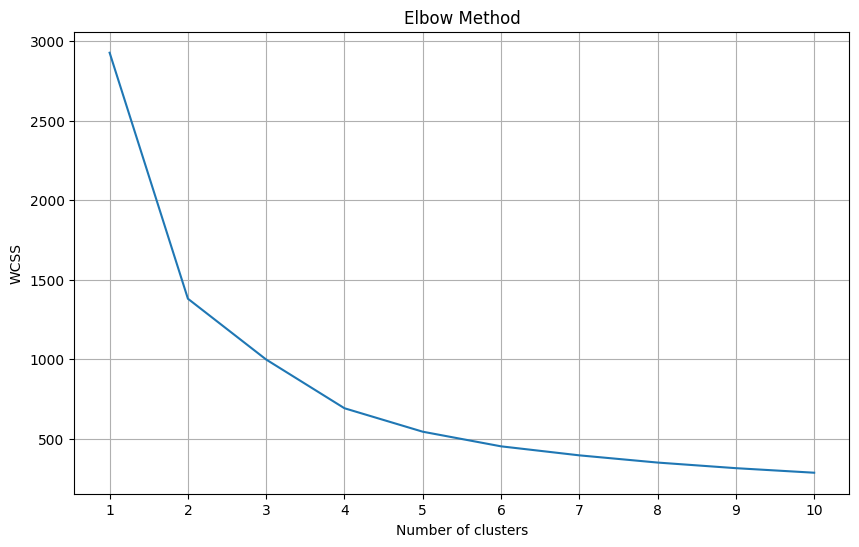

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):  # Trying different numbers of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe the 'Elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

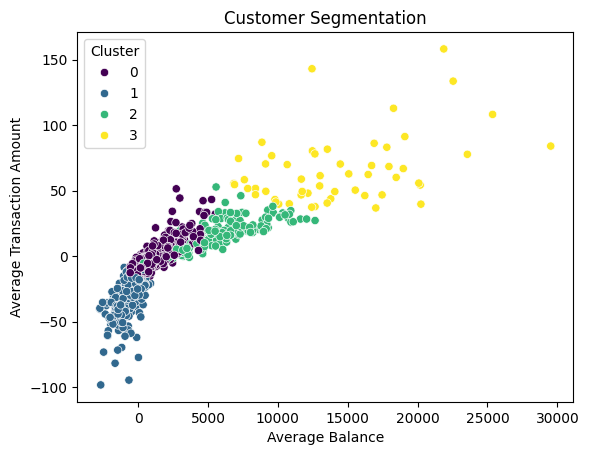

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=customer_metrics, x='Average_Balance', y='Average_Amount', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Average Balance')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Cluster')
plt.show()

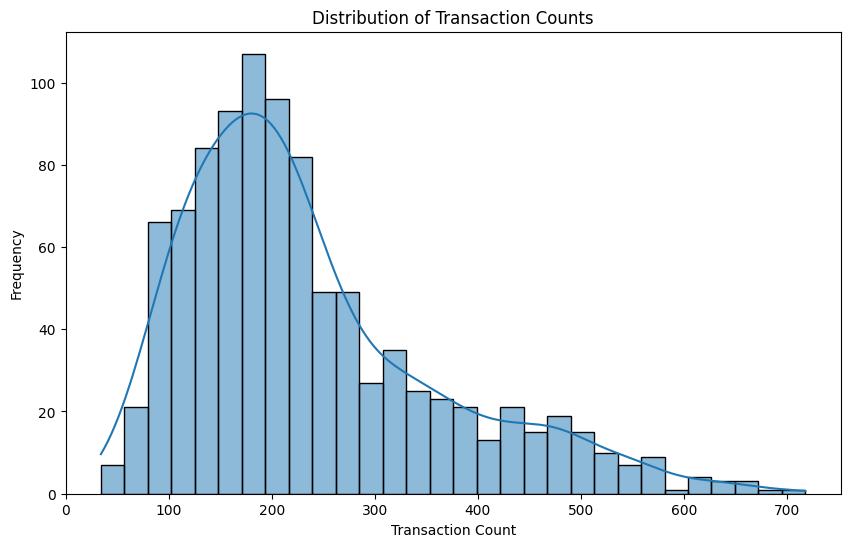

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(customer_metrics['Transaction_Count'], bins=30, kde=True)
plt.title('Distribution of Transaction Counts')
plt.xlabel('Transaction Count')
plt.ylabel('Frequency')
plt.show()

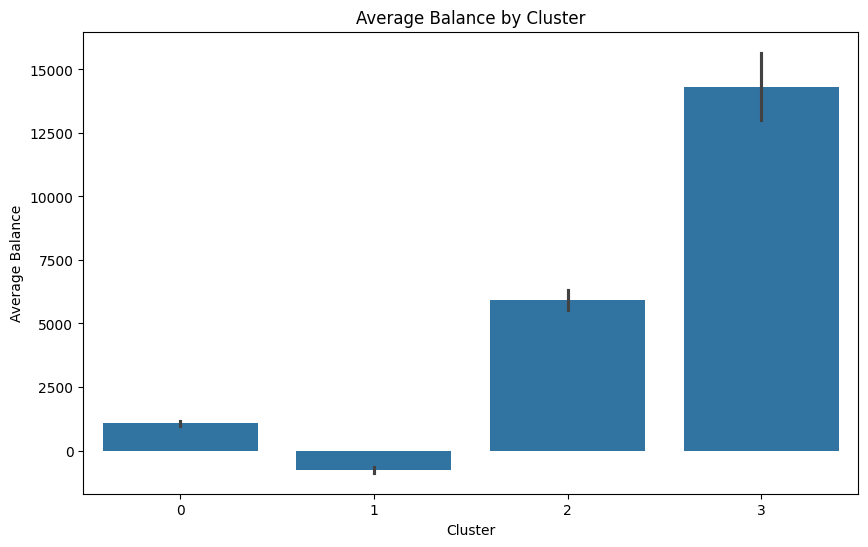

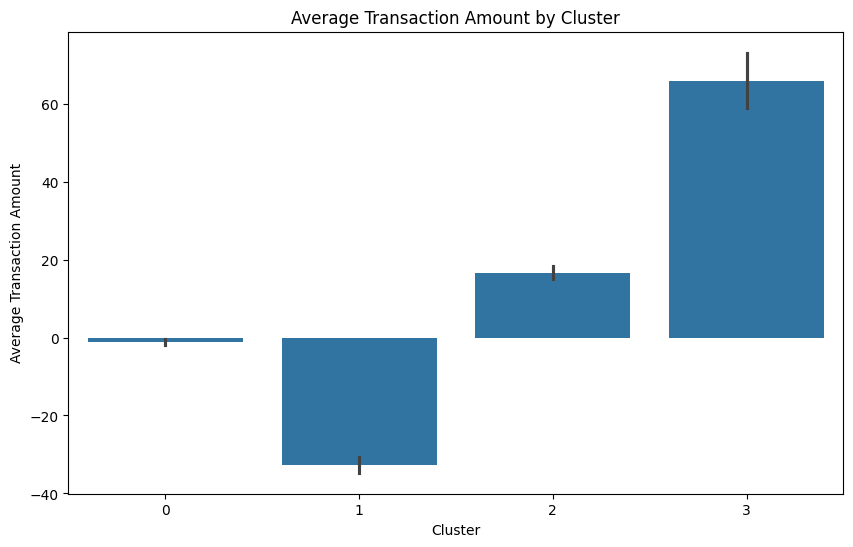

In [12]:
# Average Balance by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Average_Balance', data=customer_metrics)
plt.title('Average Balance by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Balance')
plt.show()

# Average Transaction Amount by Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Average_Amount', data=customer_metrics)
plt.title('Average Transaction Amount by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Transaction Amount')
plt.show()

In [13]:
# Example: Simple linear regression to predict future balance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Assume 'df' has a numeric 'Future_Balance' column for prediction
X = df[['Balance', 'Amount']]  # Features
y = df['Future_Balance']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

KeyError: 'Future_Balance'

In [14]:
# Remove rows where either 'Amount' or 'Hour' is NaN
df_clean = df.dropna(subset=['Amount', 'Hour'])

KeyError: ['Hour']

In [ ]:
# Impute missing values in 'Amount' with the median (or mean, based on distribution)
df['Amount'] = df['Amount'].fillna(df['Amount'].median())

df['Hour'] = df['Hour'].fillna(df['Hour'].median())

In [ ]:
# Assuming NaN values have been handled, and 'df_clean' is the DataFrame without NaNs
features = df_clean[['Amount', 'Hour']]

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(features)

# Predict anomalies
df_clean['Anomaly'] = iso_forest.predict(features)

# Display anomalies
print(df_clean[df_clean['Anomaly'] == -1].head())

         Date Timestamp   Account No  Balance  Amount  Third Party Account No  \
0  01/01/2023     00:00  678330503.0   2971.0  1584.0                     NaN   
1  01/01/2023     00:00  472213568.0   3792.0  1950.0                     NaN   
2  01/01/2023     00:00  472213568.0   3012.0  -780.0             283027736.0   
3  01/01/2023     00:00  283027736.0   1787.0   780.0             472213568.0   
4  01/01/2023     00:00  624500124.0   3226.0  1825.0                     NaN   

     Third Party Name   DateTime  Hour  High_Transaction  Anomaly  
0  Westport Care Home 2023-01-01   0.0                 1       -1  
1    Barbiee Boutique 2023-01-01   0.0                 1       -1  
2                 NaN 2023-01-01   0.0                 0       -1  
3                 NaN 2023-01-01   0.0                 1       -1  
4            Fat Face 2023-01-01   0.0                 1       -1  


C:\Users\carlo\AppData\Local\Temp\ipykernel_40884\441553135.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Anomaly'] = iso_forest.predict(features)


In [ ]:
# Summary statistics for anomalous transactions
print(anomalies[['Amount', 'Hour']].describe())

             Amount          Hour
count  36010.000000  36010.000000
mean     273.606549      6.881838
std     1247.369964      8.828302
min   -12240.000000      0.000000
25%     -390.000000      0.000000
50%      -59.795000      0.000000
75%      660.000000     15.000000
max    12240.000000     23.000000


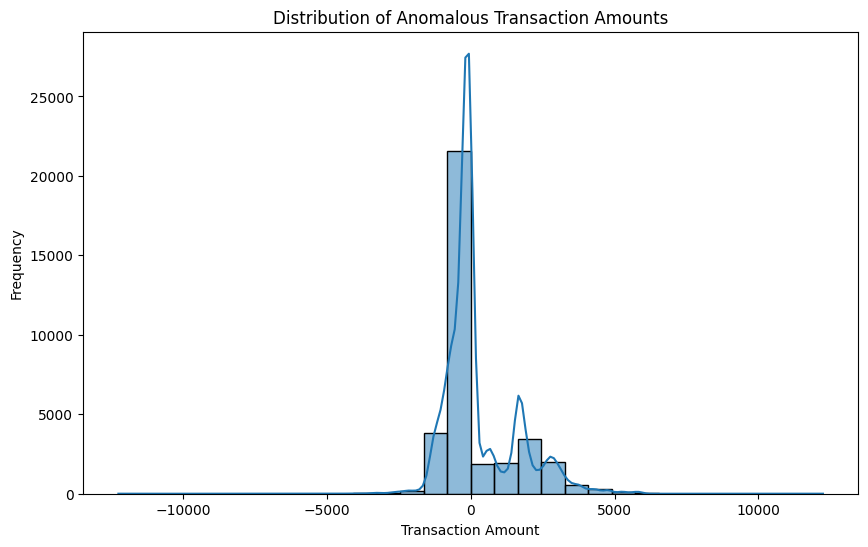

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(anomalies['Amount'], bins=30, kde=True)
plt.title('Distribution of Anomalous Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

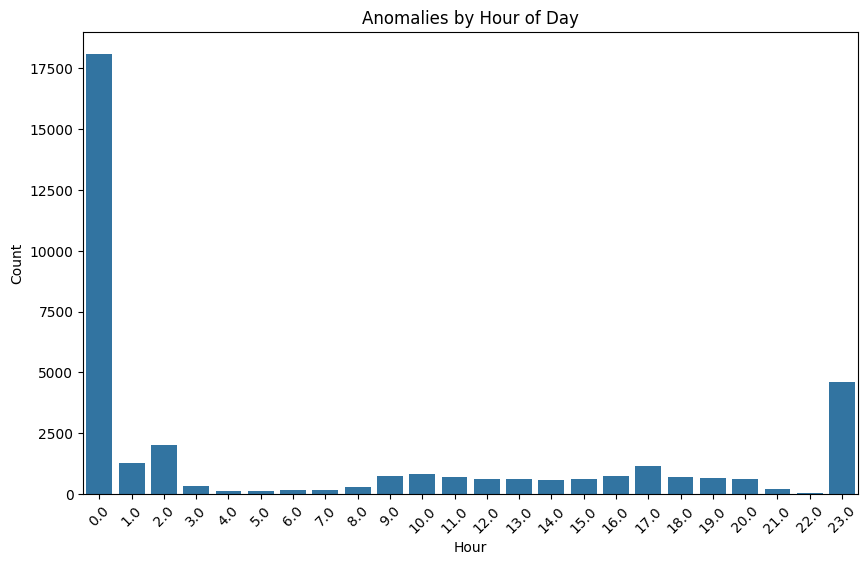

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=anomalies)
plt.title('Anomalies by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Average amount in normal transactions:  -43.16215866073915
Average amount in anomalous transactions:  273.6065487364621


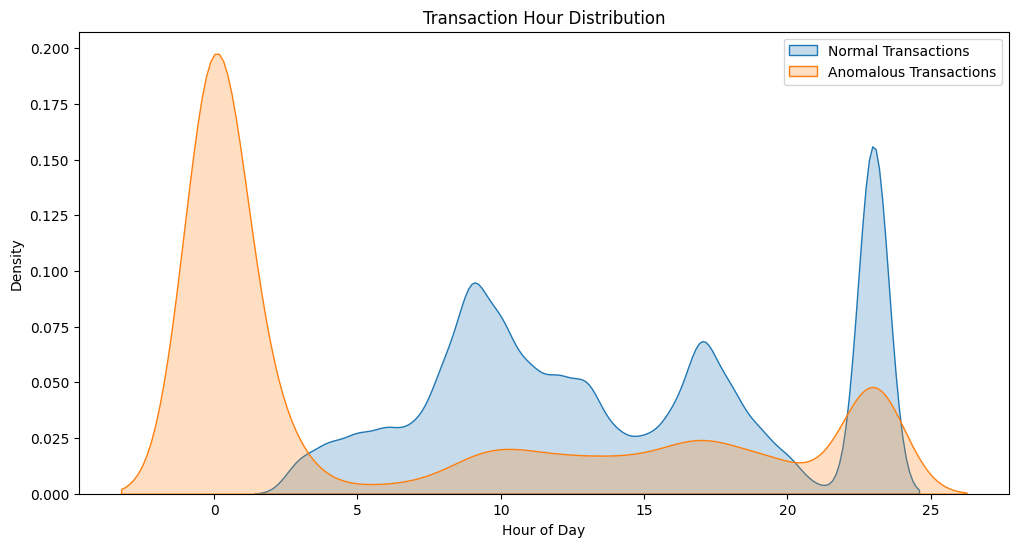

In [ ]:
# Compare the average amounts
print("Average amount in normal transactions: ", df_clean[df_clean['Anomaly'] == 1]['Amount'].mean())
print("Average amount in anomalous transactions: ", anomalies['Amount'].mean())

# Compare the distribution of transactions over hours
normal_hours = df_clean[df_clean['Anomaly'] == 1]['Hour']
anomaly_hours = anomalies['Hour']

plt.figure(figsize=(12, 6))
sns.kdeplot(normal_hours, label='Normal Transactions', fill=True)
sns.kdeplot(anomaly_hours, label='Anomalous Transactions', fill=True)
plt.title('Transaction Hour Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Density')
plt.legend()
plt.show()